# Demo code: Generative Adversarial Networks (GANs)

This demo we will demo code for using GAN model to genrate the image: 
-   Problem: Try to make a model which can generate the A-Side image of our product DCV81 

-   Dataset: A-Side dataset of our product DCV81
    -   Train folder:
        -  Total: 210 images of A-Side
-   Library packages:
    -   Numpy (Numpy arrays are very fast and can perform large computations in a very short time)
    -   PIL (Simple image processing package: read, show, resize,...)
    -   Matplotlib (Plot package: visualize result,....)
    -   TensorFlow (This is an open-source library that is used for DL/ML/AI)
    -   Scikit-Learn (Machine Learning models: KNN,SVM,Decision Tree, Metrics,...)

Tasks Outlines:
## Task 0: Preparing dataset
-   0.1. Define a function get all paths to each image in the dataset and the class label of each image
-   0.2. Define a function to get all image array and its class label (which are in typy np.array)
-   0.3. Getting data by using two previous function
-   0.4. Normalize dataset and reshape dataset to standard form
## Task 1: Constructing GAN model by using TensorFlow library:
-   1.1. Create the Generator model
-   1.2. Create the Discriminator model
-   1.3. Constructing the GAN model with overriding train_step() to train the discriminator and the generator by our training rule
-   1.4. Exploring the history of training process
## Task 2: Loading the trained model and Exploring the Generator model in trained model
-   2.1. Loading the trained model.
-   2.2. Exploring the Generator part of the trained model
*****************************************************************************


## Import all packages

In [1]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers


## Task 0: Preparing Dataset

### 0.1. Define a function get all paths to each image in the dataset and the class label of each image

In [2]:
def get_all_img_path(input_dir:str,
                            img_suffix = '.bmp')->list:
    """
    parameters:
    -   input_dir: the directory to the data folder
    -   img_suffix: siffix type of image in the data folder to read
    output: a list:
    -   List of all path to each image in the data folder
    """
    list_img_paths = []
    for root,dirs,files in os.walk(input_dir):
        for file in files:
            file_path = os.path.join(root,file)
            file_name,file_suffix = os.path.splitext(file)
            if file_suffix == img_suffix:
                list_img_paths.append(file_path)
    return list_img_paths

### 0.2. Define a function to get all image array and its class label (which are in type np.array)
In this function we also resize the all image to the same new size = (width, height)

In [3]:
# Resize the image to small dimensional of width and height
def get_data(list_img_paths:list,
             is_resize:bool= True,
             width:int = 32,
             height:int = 32) -> np.array:
    """
    Parameters:
    -   list_img_paths: List of all paths to image in the data folder
    -   is_resize: Default is True means resize all image in the dataset
        to the new size (width,height)
    -   width: The width size which we want to resize to
    -   height: The height size which we want to resize to

    Output: An array
    -   data_array with shape (N,h,w), where
        -   N is the number of image
        -   h is the height
        -   w is the width
    """
    data = []
    for i in range(len(list_img_paths)):
        path_img = list_img_paths[i]
        img = Image.open(path_img).convert('L')
        if is_resize:
            img = img.resize(size = (width,height),
                            resample=Image.BICUBIC)
        data.append(np.array(img))
    return np.array(data)

### 0.3. Getting data by using two previouse function

In [4]:
# Setting for image shape
width = 32 # <--- width of image:
height = 32 # <--- height of image:
n_channels = 1

In [5]:
# Get the list images path and list labels of train, val, test
data_dir = "/Users/user/Victor2023/Dataset/Data_GAN" # Replace this directory by the directory to data in your computer
data_dir = "D:\APPLY_JOB_2023\Data\ASink\Data_GAN_DCV81"
list_imgs = get_all_img_path(input_dir=data_dir,
                                   img_suffix='.bmp')


In [6]:
X_train = get_data(list_img_paths=list_imgs,
               is_resize=True,
               width=width,
               height= height)

### 0.4. Normalize dataset and reshape dataset to standard form

#### Warning !!

The shape of data image input for CNN model_G should be (N_samples,height, width, n_channels). In which:
-   N_samples: The total number of samples we have (number of images)
-   height: the height of image
-   width: the width of image
-   n_channels: number of channels in image (our case is gray scale image => n_channels = 1)

Back to our data:
-   Data is image in grayscale we resize to same size (height,width). The number of channels in image is 1 
-   We have to reshape our data from (N_samples,height,width) to (N_samples,height,width,n_channels)

In [7]:
n_samples_train = X_train.shape[0]
X_train = X_train.reshape((n_samples_train,height,width,n_channels))
# Normalize feature from range [0,255] to range [-1,1] which is the range of the tanh activation
X_train = (X_train - 127.5)/127.5

In [8]:
print("The currently shape of input dataset X is:", X_train.shape)

The currently shape of input dataset X is: (210, 32, 32, 1)


Show some images of the train set:


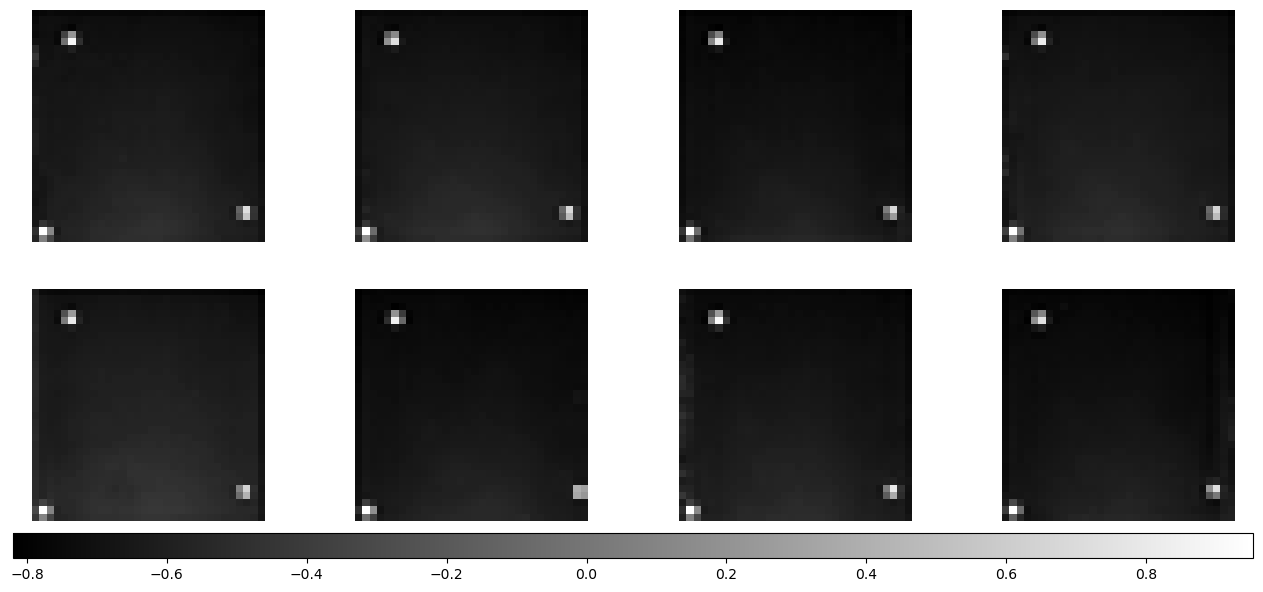

In [9]:
print("Show some images of the train set:")
nrows = 2
ncols = 4
fig,axes = plt.subplots(nrows = nrows,ncols = ncols, figsize= (16,8))
for r in range(2):
    for c in range(4):
        index = r*4 + c
        axes[r,c].set_axis_off()
        image = X_train[index].reshape((width,height))
        photo = axes[r,c].imshow(image, cmap = 'gray', interpolation = "nearest")
fig.colorbar(photo, ax=axes.ravel().tolist(), orientation='horizontal',aspect=50,pad=0.02)

In [11]:
print(height//2)

16


## Task 1: Constructing GAN model by using TensorFlow library:

### 1.1. Create the Generator Model

The Generator model (G model) takes random noise as an input and outputs an image that resembles the training images. Here, we configure the G model to generate a gray-scale image of size (height,width,n_channel).

-   The 1st layer is Dense (fully connected) layer
-   The 2nd layer is Upsampling layer (Conv2DTranspose)
-   The 3rd layer is Upsampling layer (Conv2DTranspose)
-   The final layer is Conv2D layer with activation of tanh to make an image of shape (height,width,n_channel).


In [10]:
# Dimension of the random noise
NOISE_DIM = 100
# Weight initializer for G model
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02,seed=1)

### Warning !!
We have to define the size of feature under the dense layer to make sure the generator work correctly and it will generate the image of the shape (height,width,n_channels):
-   Let denote the size of feature under the dense layer is : d_size. In order to make it easier to compute we assume the size can be written as following form:
    -   d_size = d_height * d_width * d_number
-   To connect the Dense layer with the 2nd layer (Upsampling layer), we have to reshape the output feature of Dense to the shape of form (d_height,d_width,d_number)
-   Under the 2nd layer ( Conv2DTranspose with filters = 128, strides = (2,2),) the output of this layer will have the shape (2*d_height,2*d_width,128)
-   Under the 3rd layer ( Conv2DTranspose with filters = 64, strides = (2,2),) the output of this layer will have the shape (2*2*d_height,2*2*d_width,64)
-   Under the last layer (Conv2D with filters = n_channels, strides = (1,1),padding = 'same') the output of this layer will have the shape (2*2*d_height,2*2*d_width,n_channels)
-   We want generator model will return an image of shape (height,withd,n_channels)
-   => (2*2*d_height,2*2*d_width,n_channels) = (height,width,n_channels)
-   => d_height = height/4, d_width = width/4

In [16]:
# Define the output shape of dense layer
d_height = height//4
d_width = width //4
d_number = 128 #<---- any number

In [17]:
# Create Generator model
model_G = Sequential(name='generator')

In [18]:
# Construct the 1st layer: Dense layer 
model_G.add(layers.Dense(d_height*d_width*d_number, input_dim = NOISE_DIM))
model_G.add(layers.BatchNormalization())
model_G.add(layers.ReLU())
# Reshape
model_G.add(layers.Reshape((d_height,d_width,d_number)))

In [19]:
# Construct the 2nd layer
# Upsample to 32x32: Applying a transpose CONV => BatchNormalization => Actiation ReLU
model_G.add(layers.Conv2DTranspose(filters = 128,
                                 kernel_size=(5,5),
                                 strides=(2,2),
                                 padding='same',
                                 kernel_initializer=WEIGHT_INIT))
model_G.add(layers.BatchNormalization())
model_G.add(layers.ReLU())

In [20]:
# Construct the 3rd layer
# Upsample to 64x64: Applying a transpose CONV => BatchNormalization => Activation ReLu
model_G.add(layers.Conv2DTranspose(filters = 64,
                                 kernel_size = (5,5),
                                 strides = (2,2),
                                 padding = 'same',
                                 kernel_initializer = WEIGHT_INIT))
model_G.add(layers.BatchNormalization())
model_G.add(layers.ReLU())

In [21]:
# Finally, use a CONV2D layer with activation of tanh to make an image of shape 64x64x1.
model_G.add(layers.Conv2D(filters = n_channels,
                        kernel_size = (5,5),
                        padding = 'same',
                        activation = 'tanh'))

In [22]:
# Show the model summary
model_G.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      409728    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      51

### 1.2. Create the Discriminator Model
The Discriminator model (model_D) is a simple binary classifier that tells whether an image is real or fake. The input data for this model will be from train dataset and images which are generated from model_G

-   The 1st layer is Conv2D layer
-   The 2nd layer is Conv2D layer
-   The last layer is Dense layer (Fully-Connected layer)

In [23]:
model_D = Sequential(name='discriminator')
input_shape = (height,width,n_channels)

In [24]:
# first set of CONV => BN => leaky ReLU layers
model_D.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same",
   input_shape=input_shape))
model_D.add(layers.BatchNormalization())
model_D.add(layers.LeakyReLU(alpha=0.2))

# second set of CONV => BN => leaky ReLU layers
model_D.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
model_D.add(layers.BatchNormalization())
model_D.add(layers.LeakyReLU(alpha=0.2))

model_D.add(layers.Flatten())
model_D.add(layers.Dropout(0.3))
model_D.add(layers.Dense(1, activation="sigmoid"))

In [25]:
# Show the model_D summary
model_D.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        1664      
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)       

### 1.3. Constructing the GAN model with overriding train_step to train the discriminator and the generator by our training rule

In [26]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, noise_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.noise_dim = noise_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.noise_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        # G wants D to think the fake images are real (label as 1)
        misleading_labels = tf.ones((batch_size, 1)) 

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [27]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, noise_dim=100):
        self.num_img = num_img
        self.noise_dim = noise_dim

        # Create random noise seed for visualization during training
        self.seed = tf.random.normal([16, noise_dim])

    def on_epoch_end(self, epoch, logs=None):

        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        # plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [28]:
model_GAN = GAN(discriminator=model_D, generator=model_G, noise_dim=NOISE_DIM)

In [29]:
LR = 0.0002 # learning rate

model_GAN.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

Epoch 1/50
7/7 [==============================] - ETA: 0s - d_loss: 0.4297 - g_loss: 1.5711

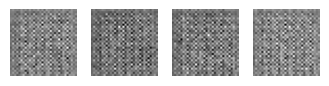

7/7 [==============================] - 5s 281ms/step - d_loss: 0.4297 - g_loss: 1.5711
Epoch 2/50
7/7 [==============================] - ETA: 0s - d_loss: 0.1288 - g_loss: 2.9197

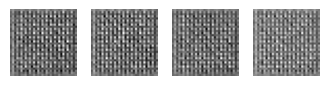

7/7 [==============================] - 2s 262ms/step - d_loss: 0.1288 - g_loss: 2.9197
Epoch 3/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0432 - g_loss: 2.4040

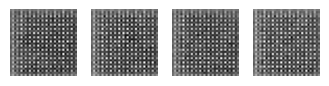

7/7 [==============================] - 2s 280ms/step - d_loss: 0.0432 - g_loss: 2.4040
Epoch 4/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0057 - g_loss: 1.4148

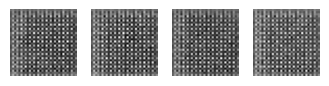

7/7 [==============================] - 2s 260ms/step - d_loss: 0.0057 - g_loss: 1.4148
Epoch 5/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0042 - g_loss: 1.1590

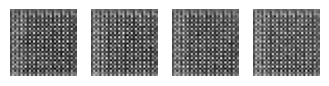

7/7 [==============================] - 2s 243ms/step - d_loss: 0.0042 - g_loss: 1.1590
Epoch 6/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0033 - g_loss: 1.1821

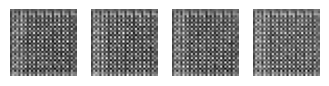

7/7 [==============================] - 2s 262ms/step - d_loss: 0.0033 - g_loss: 1.1821
Epoch 7/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0028 - g_loss: 1.2024

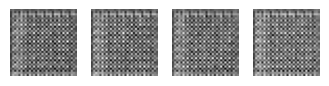

7/7 [==============================] - 2s 311ms/step - d_loss: 0.0028 - g_loss: 1.2024
Epoch 8/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0040 - g_loss: 0.8732

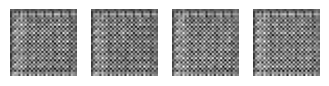

7/7 [==============================] - 2s 291ms/step - d_loss: 0.0040 - g_loss: 0.8732
Epoch 9/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0029 - g_loss: 0.9870

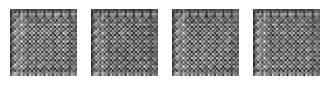

7/7 [==============================] - 2s 322ms/step - d_loss: 0.0029 - g_loss: 0.9870
Epoch 10/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0021 - g_loss: 0.8222

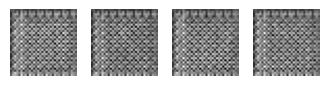

7/7 [==============================] - 2s 292ms/step - d_loss: 0.0021 - g_loss: 0.8222
Epoch 11/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0015 - g_loss: 0.6210

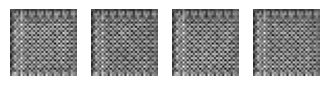

7/7 [==============================] - 2s 301ms/step - d_loss: 0.0015 - g_loss: 0.6210
Epoch 12/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0010 - g_loss: 0.5878

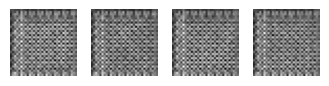

7/7 [==============================] - 2s 299ms/step - d_loss: 0.0010 - g_loss: 0.5878
Epoch 13/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0010 - g_loss: 0.6196    

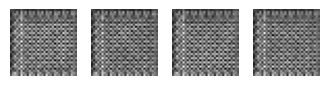

7/7 [==============================] - 2s 322ms/step - d_loss: 0.0010 - g_loss: 0.6196
Epoch 14/50
7/7 [==============================] - ETA: 0s - d_loss: 8.6938e-04 - g_loss: 0.5250

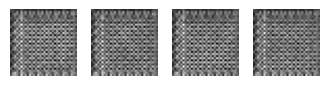

7/7 [==============================] - 2s 300ms/step - d_loss: 8.6938e-04 - g_loss: 0.5250
Epoch 15/50
7/7 [==============================] - ETA: 0s - d_loss: 8.0812e-04 - g_loss: 0.3596

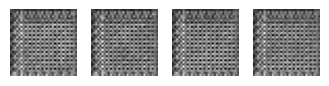

7/7 [==============================] - 2s 293ms/step - d_loss: 8.0812e-04 - g_loss: 0.3596
Epoch 16/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0011 - g_loss: 0.1881    

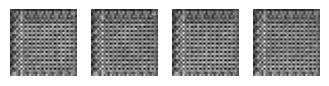

7/7 [==============================] - 2s 329ms/step - d_loss: 0.0011 - g_loss: 0.1881
Epoch 17/50
7/7 [==============================] - ETA: 0s - d_loss: 5.6363e-04 - g_loss: 0.2041

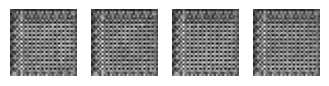

7/7 [==============================] - 2s 299ms/step - d_loss: 5.6363e-04 - g_loss: 0.2041
Epoch 18/50
7/7 [==============================] - ETA: 0s - d_loss: 5.7609e-04 - g_loss: 0.2253

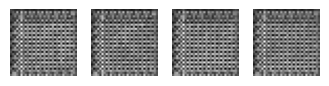

7/7 [==============================] - 2s 321ms/step - d_loss: 5.7609e-04 - g_loss: 0.2253
Epoch 19/50
7/7 [==============================] - ETA: 0s - d_loss: 4.5735e-04 - g_loss: 0.2294

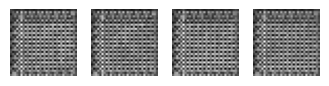

7/7 [==============================] - 2s 292ms/step - d_loss: 4.5735e-04 - g_loss: 0.2294
Epoch 20/50
7/7 [==============================] - ETA: 0s - d_loss: 4.8899e-04 - g_loss: 0.2270

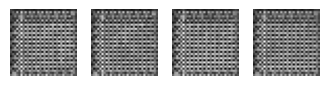

7/7 [==============================] - 2s 353ms/step - d_loss: 4.8899e-04 - g_loss: 0.2270
Epoch 21/50
7/7 [==============================] - ETA: 0s - d_loss: 4.0954e-04 - g_loss: 0.2295

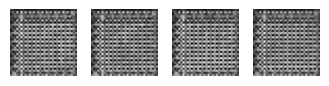

7/7 [==============================] - 2s 309ms/step - d_loss: 4.0954e-04 - g_loss: 0.2295
Epoch 22/50
7/7 [==============================] - ETA: 0s - d_loss: 4.0598e-04 - g_loss: 0.2510

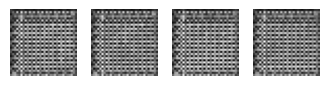

7/7 [==============================] - 2s 294ms/step - d_loss: 4.0598e-04 - g_loss: 0.2510
Epoch 23/50
7/7 [==============================] - ETA: 0s - d_loss: 5.1551e-04 - g_loss: 0.2560

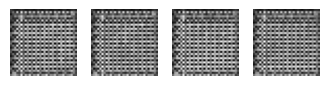

7/7 [==============================] - 3s 448ms/step - d_loss: 5.1551e-04 - g_loss: 0.2560
Epoch 24/50
7/7 [==============================] - ETA: 0s - d_loss: 4.8670e-04 - g_loss: 0.3004

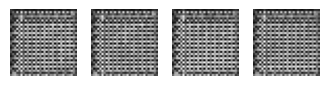

7/7 [==============================] - 2s 293ms/step - d_loss: 4.8670e-04 - g_loss: 0.3004
Epoch 25/50
7/7 [==============================] - ETA: 0s - d_loss: 5.2857e-04 - g_loss: 0.3256

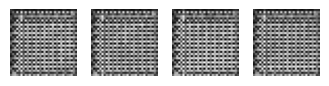

7/7 [==============================] - 2s 308ms/step - d_loss: 5.2857e-04 - g_loss: 0.3256
Epoch 26/50
7/7 [==============================] - ETA: 0s - d_loss: 4.8654e-04 - g_loss: 0.4308

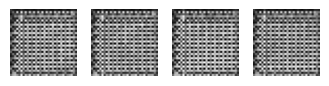

7/7 [==============================] - 2s 295ms/step - d_loss: 4.8654e-04 - g_loss: 0.4308
Epoch 27/50
7/7 [==============================] - ETA: 0s - d_loss: 4.8116e-04 - g_loss: 0.5213

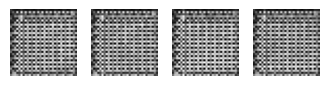

7/7 [==============================] - 2s 302ms/step - d_loss: 4.8116e-04 - g_loss: 0.5213
Epoch 28/50
7/7 [==============================] - ETA: 0s - d_loss: 6.5740e-04 - g_loss: 0.6538

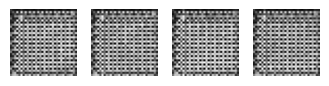

7/7 [==============================] - 2s 306ms/step - d_loss: 6.5740e-04 - g_loss: 0.6538
Epoch 29/50
7/7 [==============================] - ETA: 0s - d_loss: 3.7181e-04 - g_loss: 0.8053

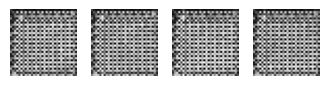

7/7 [==============================] - 2s 264ms/step - d_loss: 3.7181e-04 - g_loss: 0.8053
Epoch 30/50
7/7 [==============================] - ETA: 0s - d_loss: 5.7609e-04 - g_loss: 0.9932

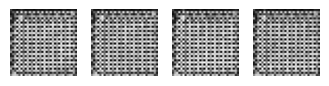

7/7 [==============================] - 2s 333ms/step - d_loss: 5.7609e-04 - g_loss: 0.9932
Epoch 31/50
7/7 [==============================] - ETA: 0s - d_loss: 4.9183e-04 - g_loss: 1.1608

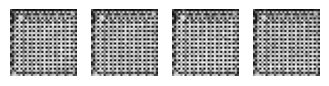

7/7 [==============================] - 2s 295ms/step - d_loss: 4.9183e-04 - g_loss: 1.1608
Epoch 32/50
7/7 [==============================] - ETA: 0s - d_loss: 6.1725e-04 - g_loss: 1.4272

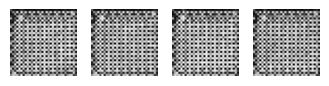

7/7 [==============================] - 2s 345ms/step - d_loss: 6.1725e-04 - g_loss: 1.4272
Epoch 33/50
7/7 [==============================] - ETA: 0s - d_loss: 5.7481e-04 - g_loss: 1.5357

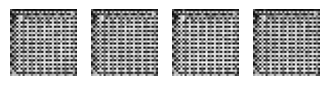

7/7 [==============================] - 3s 421ms/step - d_loss: 5.7481e-04 - g_loss: 1.5357
Epoch 34/50
7/7 [==============================] - ETA: 0s - d_loss: 5.5663e-04 - g_loss: 1.7081

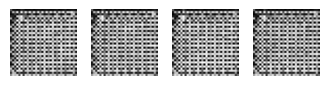

7/7 [==============================] - 3s 370ms/step - d_loss: 5.5663e-04 - g_loss: 1.7081
Epoch 35/50
7/7 [==============================] - ETA: 0s - d_loss: 6.2969e-04 - g_loss: 1.8858

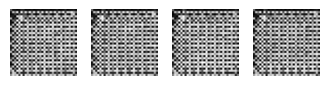

7/7 [==============================] - 2s 331ms/step - d_loss: 6.2969e-04 - g_loss: 1.8858
Epoch 36/50
7/7 [==============================] - ETA: 0s - d_loss: 7.7229e-04 - g_loss: 2.4762

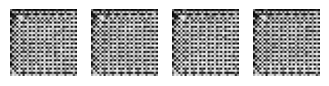

7/7 [==============================] - 2s 338ms/step - d_loss: 7.7229e-04 - g_loss: 2.4762
Epoch 37/50
7/7 [==============================] - ETA: 0s - d_loss: 9.1283e-04 - g_loss: 2.7207

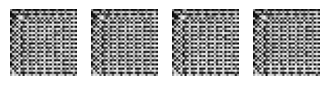

7/7 [==============================] - 2s 322ms/step - d_loss: 9.1283e-04 - g_loss: 2.7207
Epoch 38/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0015 - g_loss: 2.8909

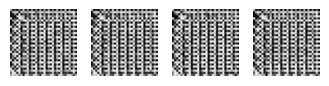

7/7 [==============================] - 2s 338ms/step - d_loss: 0.0015 - g_loss: 2.8909
Epoch 39/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0028 - g_loss: 3.7363

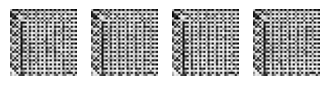

7/7 [==============================] - 4s 612ms/step - d_loss: 0.0028 - g_loss: 3.7363
Epoch 40/50
7/7 [==============================] - ETA: 0s - d_loss: 7.6969e-04 - g_loss: 4.5828

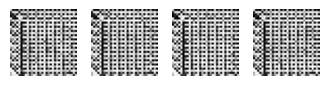

7/7 [==============================] - 3s 358ms/step - d_loss: 7.6969e-04 - g_loss: 4.5828
Epoch 41/50
7/7 [==============================] - ETA: 0s - d_loss: 6.4784e-04 - g_loss: 4.8098

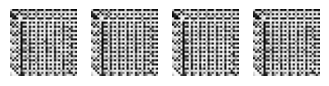

7/7 [==============================] - 2s 300ms/step - d_loss: 6.4784e-04 - g_loss: 4.8098
Epoch 42/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0015 - g_loss: 4.9220

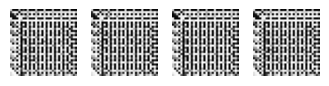

7/7 [==============================] - 2s 313ms/step - d_loss: 0.0015 - g_loss: 4.9220
Epoch 43/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0028 - g_loss: 5.6819

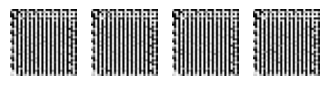

7/7 [==============================] - 2s 331ms/step - d_loss: 0.0028 - g_loss: 5.6819
Epoch 44/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0039 - g_loss: 5.8032

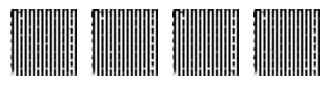

7/7 [==============================] - 2s 315ms/step - d_loss: 0.0039 - g_loss: 5.8032
Epoch 45/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0020 - g_loss: 5.5557

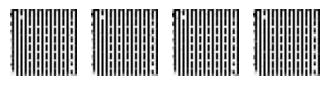

7/7 [==============================] - 2s 329ms/step - d_loss: 0.0020 - g_loss: 5.5557
Epoch 46/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0021 - g_loss: 5.8722

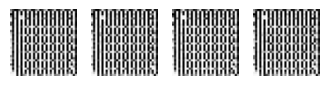

7/7 [==============================] - 2s 320ms/step - d_loss: 0.0021 - g_loss: 5.8722
Epoch 47/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0023 - g_loss: 5.8520

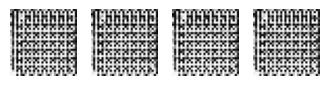

7/7 [==============================] - 2s 314ms/step - d_loss: 0.0023 - g_loss: 5.8520
Epoch 48/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0035 - g_loss: 6.1855

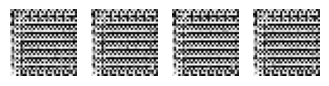

7/7 [==============================] - 2s 294ms/step - d_loss: 0.0035 - g_loss: 6.1855
Epoch 49/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0045 - g_loss: 6.1067

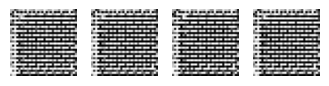

7/7 [==============================] - 2s 313ms/step - d_loss: 0.0045 - g_loss: 6.1067
Epoch 50/50
7/7 [==============================] - ETA: 0s - d_loss: 0.0055 - g_loss: 5.9578

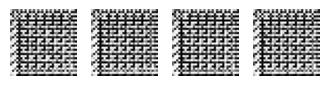

7/7 [==============================] - 2s 326ms/step - d_loss: 0.0055 - g_loss: 5.9578


In [30]:
NUM_EPOCHS = 50 # number of epochs
history = model_GAN.fit(X_train, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=4, noise_dim=NOISE_DIM)])

### 1.4. Exploring the history of training process

In [32]:
# Show the parameter in the history:
print(history.history.keys())

dict_keys(['d_loss', 'g_loss'])


In [33]:
d_loss = history.history['d_loss']
g_loss = history.history['g_loss']
epochs = range(len(d_loss))

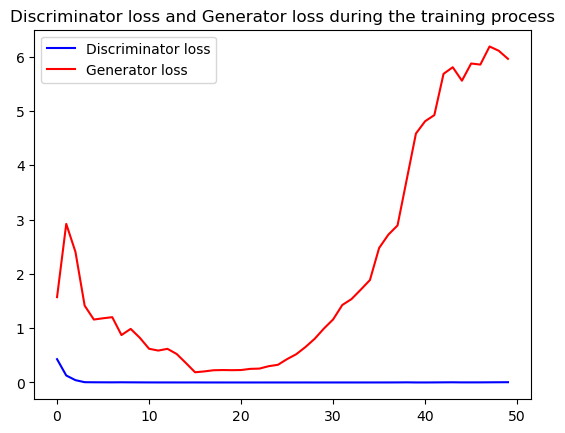

In [39]:
plt.plot(epochs, d_loss, 'b', label='Discriminator loss')
plt.plot(epochs, g_loss, 'r', label='Generator loss')
plt.title('Discriminator loss and Generator loss during the training process')
plt.legend()

## Task 2: Loading the trained model and Exploring the Generator model in trained model

### 2.1. Loading the trained model.

In [41]:
# !!!!! Replace the directory below by the directory to the best_model in your computer!
trained_model_dir = "D:\\APPLY_JOB_2023\\Victor_2023\\AI_Class\\P4_DeepLearning\\S5_GAN\\generator.h5" # <--- Change this directory
load_model = keras.models.load_model(trained_model_dir,compile=False)

In [42]:
load_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      409728    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      51

### 2.2 Exploring the Generator part of the trained model

In [44]:
# Define how many image we want to generate
n_images = 16
noise = tf.random.normal(shape=(n_images,NOISE_DIM))
# Generate images
fake_images = load_model(noise)

In [49]:
# Scale fake_image from range [-1,1] to [0,255]
fake_images = (fake_images * 127.5) + 127.5
# Change the tensor to numpy to visual the result
fake_images = fake_images.numpy()

Show the generate images:


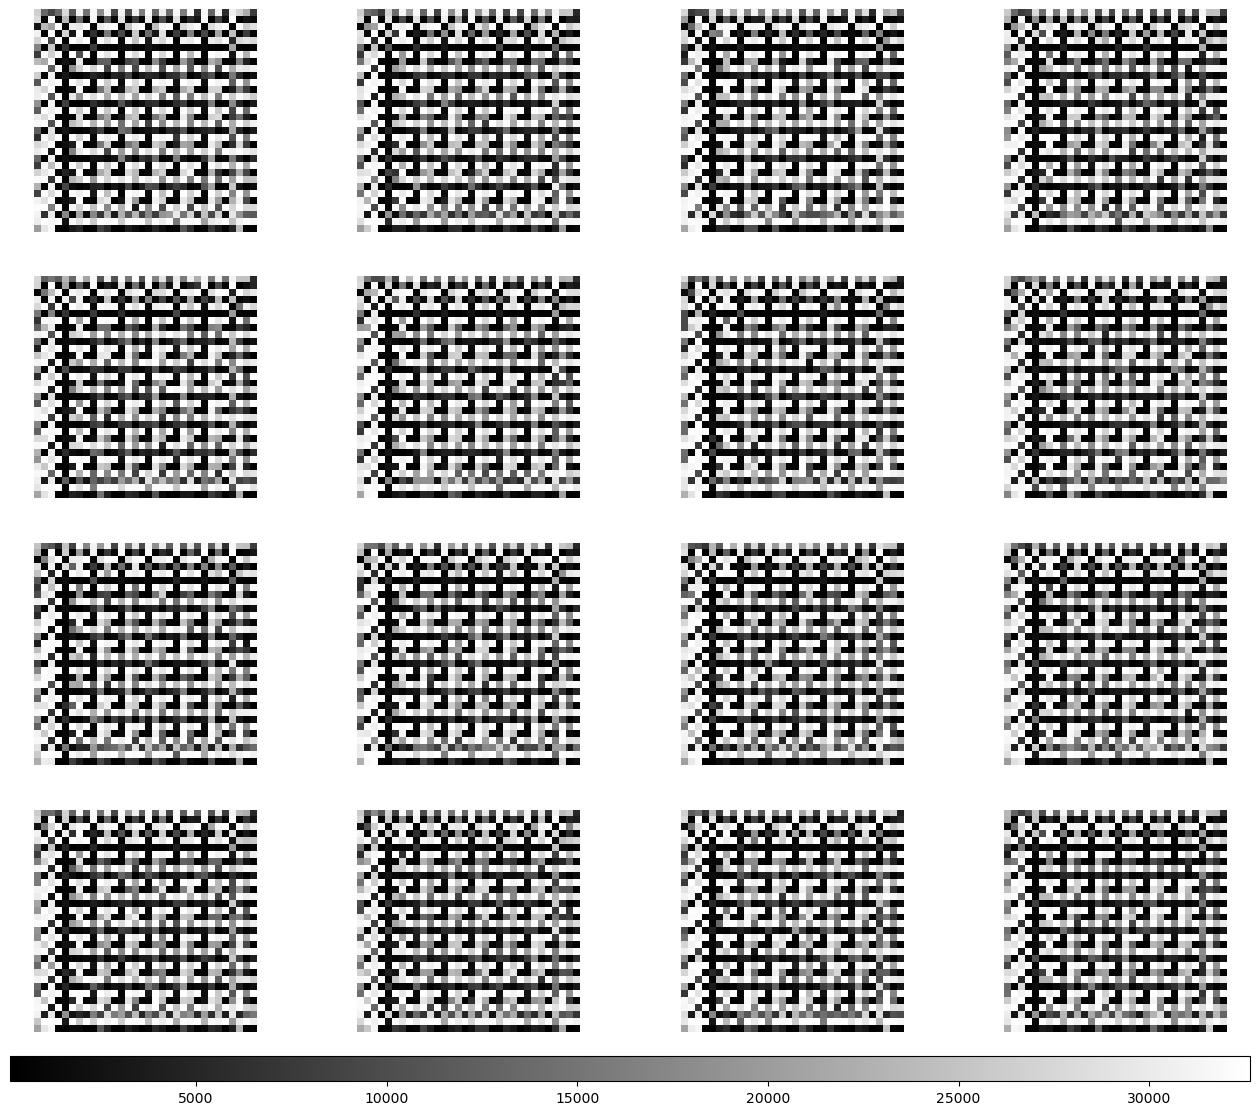

In [51]:
print("Show the generate images:")
nrows = 4
ncols = 4
fig,axes = plt.subplots(nrows = nrows,ncols = ncols, figsize= (16,16))
for r in range(4):
    for c in range(4):
        index = r*4 + c
        axes[r,c].set_axis_off()
        image = fake_images[index].reshape((height,width))
        photo = axes[r,c].imshow(image, cmap = 'gray', interpolation = "nearest")
fig.colorbar(photo, ax=axes.ravel().tolist(), orientation='horizontal',aspect=50,pad=0.02)